# 2020 Presidential Election Time Series
## Project Setup

In [32]:
%run get_data.py

Repo: 'origin': https://github.com/ElectProject/Early-Vote-2020G.git
Total commits: 1391
docs/index.html commits: 630


,commit,datetime,vote_id,vote_total,request_id,request_total
1,b08bbf24ca702e2afcc2de328fac088de8b40611,2020-11-02 19:21:00-05:00,total-voted,97930638,mail-ballots-requested,92080792
2,ae022df88d5eebb8aac062a09501ef3dbe99d889,2020-11-02 18:57:00-05:00,total-voted,97889878,mail-ballots-requested,92080792
4,cb1e7370c61cac4ef5481775d93440938ae8a6a5,2020-11-02 18:30:00-05:00,total-voted,97867186,mail-ballots-requested,92080792
5,200af095b5133300183a891b34e06348fa44bd7c,2020-11-02 18:15:00-05:00,total-voted,97771476,mail-ballots-requested,92001544
7,2d4fbcd3ac2513f2d145220735a1adc3c8828290,2020-11-02 15:57:00-05:00,total-voted,97665370,mail-ballots-requested,91973327
...,...,...,...,...,...,...
625,55ef4d8da4c860460a99cff8d2e7dac0605a857d,2020-09-01 22:55:00-04:00,NaN,NaN,NaN,12743272
626,ff3f92d8e11b8a23335cddf64e5799c74912ec52,2020-09-01 22:08:00-04:00,NaN,NaN,NaN,12623324
627,52ba37e4bd3605ab83b71358536ddf26d54b395d,2020-09-01 20:43:00-04:00,NaN,NaN,national-statistics,12623324
628,d34181643d565305eff7486090acbe9329c48d31,2020-09-01 15:48:00-04:00,NaN,NaN,national-statistics,12623324


,datetime,vote_total_2016
0,2020-09-25 22:59:00-04:00,9525
1,2020-10-02 22:59:00-04:00,74836
2,2020-10-09 22:59:00-04:00,429337
3,2020-10-16 22:59:00-04:00,1400000
4,2020-10-23 22:59:00-04:00,5900000
5,2020-10-30 22:59:00-04:00,21000000
6,2020-11-02 22:59:00-05:00,46220922
7,2020-11-03 22:59:00-05:00,136452150


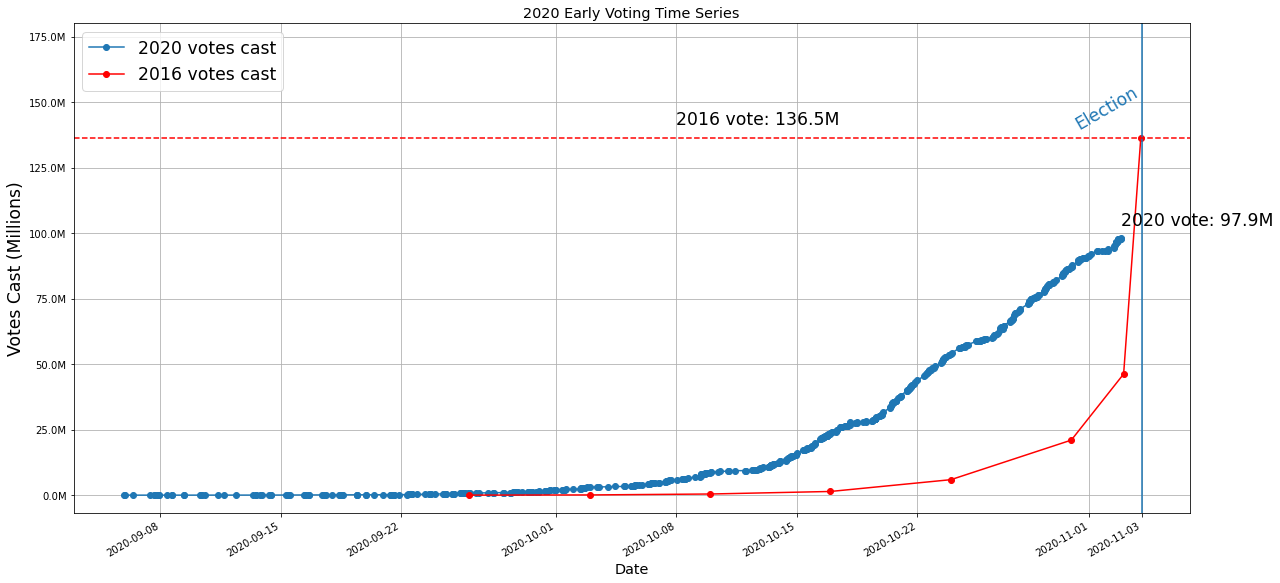

Loading BokehJS ...

In [33]:
update_notebook()